# ALS

In [1]:
# set the environment path to find Recommenders
import os 
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
import sys
import pandas as pd
import implicit
import numpy as np
import scipy.sparse as sparse
from functools import wraps
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k, diversity, novelty, serendipity, distributional_coverage, catalog_coverage 
from recommenders.tuning.parameter_sweep import generate_param_grid
from recommenders.utils.timer import Timer

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))

System version: 3.7.10 | packaged by conda-forge | (default, Oct 13 2021, 20:45:05) 
[Clang 11.1.0 ]
Pandas version: 1.1.5


In [2]:
#utils

# results table
cols = ["Data", "Algo", "K", "Train time (s)","Predicting time (s)", "RMSE", "MAE", "R2", "Explained Variance", "Recommending time (s)", "MAP", "nDCG@k", "Precision@k", "Recall@k","Diversity","Novelty","Distributional coverage","Catalog coverage"]
df_results = pd.DataFrame(columns=cols)

def generate_summary(data, algo, k, train_time, rating_time, rating_metrics, ranking_time, ranking_metrics, diversity_metrics):
    summary = {"Data": data, "Algo": algo, "K": k, "Train time (s)": train_time, "Predicting time (s)": rating_time, "Recommending time (s)":ranking_time}
    if rating_metrics is None:
        rating_metrics = {
            "RMSE": np.nan,
            "MAE": np.nan,
            "R2": np.nan,
            "Explained Variance": np.nan,
        }
    if ranking_metrics is None:
        ranking_metrics = {
            "MAP": np.nan,
            "nDCG@k": np.nan,
            "Precision@k": np.nan,
            "Recall@k": np.nan,
        }
    if diversity_metrics is None:
        diversity_metrics = {
        "Diversity": np.nan,
        "Novelty": np.nan,
        "Distributional coverage": np.nan,
        "Catalog coverage": np.nan,
    }
    summary.update(diversity_metrics)
    summary.update(rating_metrics)
    summary.update(ranking_metrics)

    return summary


def convert_timestamp(datetime):
    date_string = str(datetime)
    date = datetime.datetime.strptime(date_string, "%m/%d/%Y")
    timestamp = datetime.datetime.timestamp(date)
    return(timestamp)

def preprocess_data(df):
    # Convert the float precision to 32-bit in order to reduce memory consumption 
    df.loc[:, header["col_rating"]] = df[header["col_rating"]].astype(np.float32)
    # Convert to timestamp
    df[header["col_timestamp"]] = df[header["col_timestamp"]].apply(lambda x: int(pd.to_datetime(pd.Timestamp(x), unit='s').strftime('%s')))
    # select only relevant cols
    df[header["col_user"]] = df[header["col_user"]].map(map_customer)
    # map col_item to int
    df.loc[:, header["col_item"]] = df[header["col_item"]].astype(int)
    # select only relevant cols
    df = df[[header["col_user"],header["col_item"],header["col_rating"],header["col_timestamp"]]]
    return df 

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        arg = args[0] if len(args)>=1 else "" 
        print('func:%r  took: %2.4f sec' % \
          (f.__name__, te-ts))
        return result
    return wrap


# 0. Config params

In [4]:
# table results 
algo = "als_cython"
ranking_metrics = None
rating_metrics = None
diversity_metrics = None
train_time = np.nan
rating_time = np.nan
ranking_time = np.nan

# column name 
header = {
    "col_user": "customer_id",
    "col_item": "variant_id",
    "col_rating": "quantity",
    "col_timestamp": "order_date",
    "col_prediction": "prediction",
}

# top k
TOP_K = 10

################ TO MODIFY ################

# date size with 3 choices : "100k","1M" and "all"
data_size = "100k"
# load splitted data 
load_splitted_data = True 

################ TO MODIFY ################

# 1. Data

# 1.1 Load data 

In [5]:
########### TO MODIFY ###########
def load_data(data_size):
    path = ""
    if data_size=="100k":
        path = '../../data/transaction_100k_df.pkl'
    elif data_size=="1M":
        path = '../../data/transaction_1M_df.pkl'
    elif data_size=="all":
        path = '../../data/transaction_all_df.pkl'
    
    if path != "":
        return pd.read_pickle(path)
    else :
        print("Please choose between 100k, 1M and all")
########### TO MODIFY ###########

In [6]:
# 2 ways to load the data
if not load_splitted_data : 
    # data not splitted 
    data = load_data(data_size)
else :
    # or  use stored splitted data to make it faster
    train = pd.read_pickle(f"../../data/train_{data_size}_df.pkl")
    test = pd.read_pickle(f"../../data/test_{data_size}_df.pkl")
    train.shape[0], test.shape[0]

## 1.2 Split the data ( skip if load_splitted_data )

In [7]:
# chrono split but it is really slow ( +1h to split 8M data ) 
if not load_splitted_data :
    train, test = python_chrono_split(data,
                                      ratio=0.75,
                                      col_user=header["col_user"],
                                      col_item=header["col_item"],
                                      col_timestamp = header["col_timestamp"]
                                     )
    train.to_pickle(f"../../data/train_{data_size}_df.pkl")
    test.to_pickle(f"../../data/test_{data_size}_df.pkl")
    train.shape[0], test.shape[0]

In [8]:
print("""
Train:
Total Ratings: {train_total}
Unique Users: {train_users}
Unique Items: {train_items}

Test:
Total Ratings: {test_total}
Unique Users: {test_users}
Unique Items: {test_items}
""".format(
    train_total=len(train),
    train_users=len(train[header["col_user"]].unique()),
    train_items=len(train[header["col_item"]].unique()),
    test_total=len(test),
    test_users=len(test[header["col_user"]].unique()),
    test_items=len(test[header["col_item"]].unique()),
))


Train:
Total Ratings: 74944
Unique Users: 720
Unique Items: 5348

Test:
Total Ratings: 24983
Unique Users: 720
Unique Items: 4090



## 1.3 Process data

In [9]:
i=0
map_customer = {}
for customer in train[header["col_user"]]:
    if customer not in map_customer:
        map_customer[customer]=i
        i+=1
train = preprocess_data(train)
test = preprocess_data(test)

sparse_item_user_train = sparse.csr_matrix((train[header["col_rating"]], (train[header["col_item"]], train[header["col_user"]])))
sparse_user_item_train = sparse.csr_matrix((train[header["col_rating"]], (train[header["col_user"]], train[header["col_item"]])))

# 2. Model

## 2.1 Define model

In [10]:
model = implicit.als.AlternatingLeastSquares(factors=50,
                                            regularization=0.01,
                                            iterations=50,
                                            calculate_training_loss=False,
                                            random_state=42
                                            )

## 2.2 Train model

In [11]:
with Timer() as train_time:
    alpha_val = 10
    data_conf = (sparse_item_user_train * alpha_val).astype('double')
    model.fit(data_conf,show_progress=True)

  0%|          | 0/50 [00:00<?, ?it/s]

## 2.4  recommend k items

In [12]:
users = []
items = []
predictions = []

list_users = train[header["col_user"]].unique()
with Timer() as ranking_time:
    for user in tqdm(list_users): 
        recommended = model.recommend(user,
                                      sparse_user_item_train,
                                      N=TOP_K,
                                      filter_already_liked_items=True
                                     )
        for item in recommended:
            idx, score = item
            items.append(idx)
            predictions.append(score)
            users.append(user)

    # Create a dataframe of artist names and scores
    top_k = pd.DataFrame({header["col_user"]: users,header["col_item"]: items, header["col_prediction"]: predictions})

  0%|          | 0/720 [00:00<?, ?it/s]

# 3. Evaluate

## 3.2 Ranking metrics 

In [13]:
args = [test, top_k]

kwargs = dict(col_user = header["col_user"],
              col_item = header["col_item"],
              col_rating = header["col_rating"],
              col_prediction = header["col_prediction"],
              relevancy_method = 'top_k', 
              k = TOP_K)

eval_map = map_at_k(*args, **kwargs)
eval_ndcg = ndcg_at_k(*args, **kwargs)
eval_precision = precision_at_k(*args, **kwargs)
eval_recall = recall_at_k(*args, **kwargs)

ranking_metrics = {
    "MAP": eval_map,
    "nDCG@k": eval_ndcg,
    "Precision@k": eval_precision,
    "Recall@k": eval_recall
}

print(f"Model:",
      f"Top K:\t\t {TOP_K}",
      f"MAP:\t\t {eval_map:f}",
      f"NDCG:\t\t {eval_ndcg:f}",
      f"Precision@K:\t {eval_precision:f}",
      f"Recall@K:\t {eval_recall:f}",sep='\n')

Model:
Top K:		 10
MAP:		 0.006227
NDCG:		 0.055221
Precision@K:	 0.051667
Recall@K:	 0.015082


## 3.2 Diversity metrics

In [90]:
args = [train, top_k]

kwargs = dict(col_user = header["col_user"],
              col_item = header["col_item"],
             )

eval_diversity = diversity(*args, **kwargs)
eval_novelty = novelty(*args, **kwargs)
eval_distributional_coverage = distributional_coverage(*args, **kwargs)
eval_catalog_coverage = catalog_coverage(*args,**kwargs)

diversity_metrics = {
    "Diversity": eval_diversity,
    "Novelty": eval_novelty,
    "Distributional coverage": eval_distributional_coverage,
    "Catalog coverage": eval_catalog_coverage,
}

print(f"Model:",
      f"Diversity :\t\t\t {eval_diversity}",
      f"Novelty:\t\t\t {eval_novelty:f}",
      f"Catalog coverage:\t\t {eval_catalog_coverage:f}",
      f"Distributional coverage:\t {eval_distributional_coverage:f}",sep='\n')

Model:
Diversity :			 0.9621140669928848
Novelty:			 10.042972
Catalog coverage:		 0.158767
Distributional coverage:	 9.149739


# 4 Summary

In [91]:
summary = generate_summary(data_size,
                           algo,
                           TOP_K,
                           train_time, 
                           rating_time,
                           rating_metrics,
                           ranking_time,
                           ranking_metrics,
                           diversity_metrics)
df_results.loc[df_results.shape[0] + 1] = summary
df_results

,Data,Algo,K,Train time (s),Predicting time (s),RMSE,MAE,R2,Explained Variance,Recommending time (s),MAP,nDCG@k,Precision@k,Recall@k,Diversity,Novelty,Distributional coverage,Catalog coverage
1,100k,als_cython,10,3.0065,NaN,NaN,NaN,NaN,NaN,4.2962,0.006227,0.055221,0.051667,0.015082,0.854077,10.217964,9.261189,0.205497
2,1M,als_cython,10,8.6742,NaN,NaN,NaN,NaN,NaN,135.8204,0.012856,0.038076,0.031262,0.030650,0.920905,10.144708,9.150357,0.234517
3,all,als_cython,10,326.4773,NaN,NaN,NaN,NaN,NaN,8666.2828,0.070028,0.098556,0.024141,0.160735,0.962114,10.042972,9.149739,0.158767


# 5 Search for best params

In [10]:
# search for best param
def search_param(alpha):
    param_dict = {
        "factors": [5,10,20,50,100,200,500,1000],
        "regularization": [0.0001,0.001,0.01,0.1]
    }
    param_grid = generate_param_grid(param_dict)
    precision_score = []

    for g in tqdm(param_grid):
        model = implicit.als.AlternatingLeastSquares(iterations=50,
                                                     random_state=42,
                                                     **g,
                                                    )
        alpha = alpha
        data_conf = (sparse_item_user_train * alpha).astype('double')
        model.fit(data_conf, show_progress=True)

        users = []
        items = []
        predictions = []

        list_users = train[header["col_user"]].unique()
        for user in tqdm(list_users): 
            recommended = model.recommend(user,
                                          sparse_user_item_train,
                                          N=TOP_K,
                                          filter_already_liked_items=True
                                         )
            for item in recommended:
                idx, score = item
                items.append(idx)
                predictions.append(score)
                users.append(user)

        # Create a dataframe of artist names and scores
        top_k = pd.DataFrame({header["col_user"]: users,header["col_item"]: items, header["col_prediction"]: predictions})

        args = [test, top_k]

        kwargs = dict(col_user = header["col_user"],
                      col_item = header["col_item"],
                      col_rating = header["col_rating"],
                      col_prediction = header["col_prediction"],
                      relevancy_method = 'top_k', 
                      k = TOP_K)
        
        eval_precision = precision_at_k(*args, **kwargs)
        
        precision_score.append(eval_precision)
    
    return precision_score

def show_plot(precision_score):
    param_dict = {
        "factors": [5,10,20,50,100,200,500,1000],
        "regularization": [0.0001,0.001,0.01,0.1]
    }
    precision_score = [float('%.4f' % x) for x in precision_score]
    precision_score_array = np.reshape(precision_score, (len(param_dict["factors"]), len(param_dict["regularization"]))) 
    precision_score_df = pd.DataFrame(data=precision_score_array, index=pd.Index(param_dict["factors"], name="factors"), 
                           columns=pd.Index(param_dict["regularization"], name="regularization"))
    fig, ax = plt.subplots()
    sns.heatmap(precision_score_df, cbar=False, annot=True, fmt=".4g")

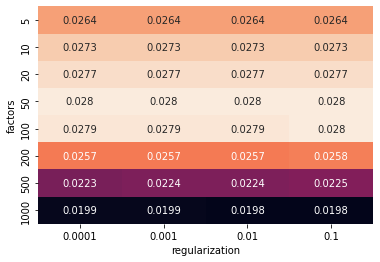

In [47]:
# alpha = 1 for 1M data
show_plot(score)

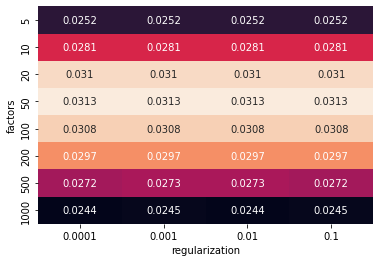

In [49]:
# alpha = 10 for 1M data
show_plot(score_1)

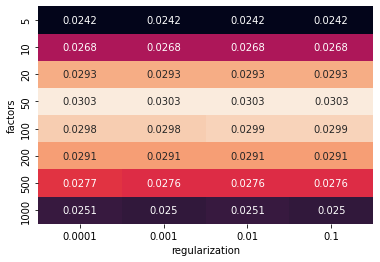

In [12]:
# alpha = 20 for 1M data
show_plot(score_2)

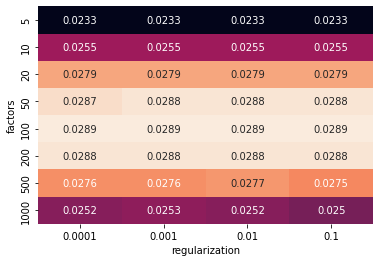

In [28]:
# alpha = 30 for 1M data
show_plot(score_3)

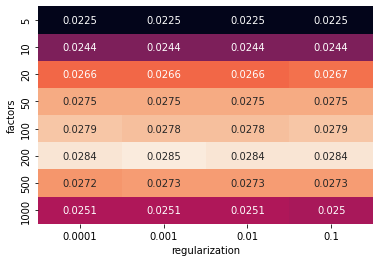

In [30]:
# alpha = 40 for 1M data
show_plot(score_4)